In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.backends import backend_pdf as bpdf
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,MakeMatrices,MakeInitialState
from community_simulator import Community
from community_simulator.visualization import PlotTraj, StackPlot
import pickle
from statsmodels.nonparametric.smoothers_lowess import lowess
import biom
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
%matplotlib inline

To run this notebook, in addition to the standard Anaconda packages, you must also install scikit-learn (https://anaconda.org/anaconda/scikit-learn), scikit-bio (https://anaconda.org/anaconda/scikit-bio) and biom-format (https://anaconda.org/bioconda/biom-format).

In [3]:
mp = {
      'regulation':'independent',
      'supply':'external',
      'response':'type I'
     }

#Construct dynamics
def dNdt(N,R,params):
    return MakeConsumerDynamics(mp)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(mp)(N,R,params)
dynamics = [dNdt,dRdt]

# Colonization Dynamics

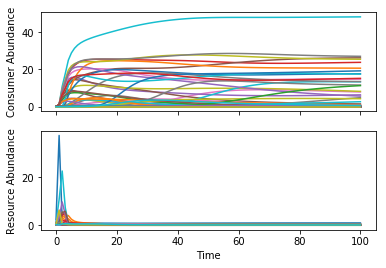

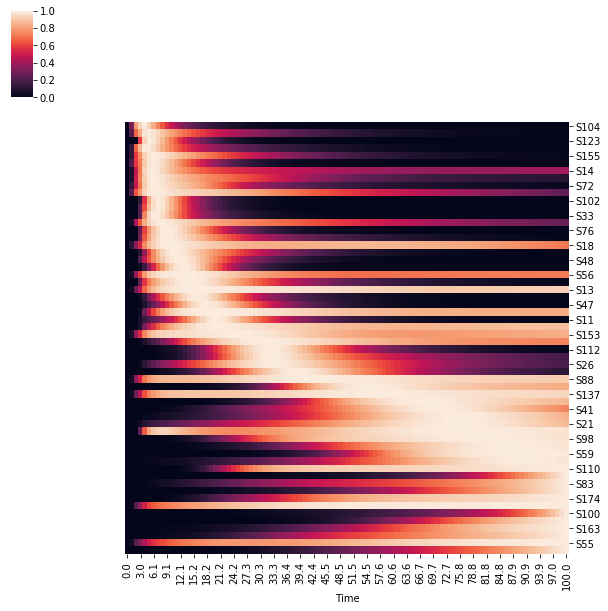

In [4]:
with open('data/EMP.dat','rb') as f:
    N0,R0,params,metadata = pickle.load(f)
well = metadata['m'].values.argmin()

N0 = np.ones(len(N0))*1e-6
test_colony = Community([N0,R0.values[:,0]],dynamics,params[well])

out = test_colony.TestWell(T = 100)
Ntraj = pd.DataFrame(out[1],index = pd.Series(np.around(out[0],decimals=1),name='Time'),columns = test_colony.N.index).T
Ntraj = Ntraj.loc[Ntraj.T.max()>0.01]
t_max = np.argmax(Ntraj.values,axis=1)
Ntraj['t_max'] = t_max
Ntraj = Ntraj.sort_values('t_max')
del Ntraj['t_max']
sns.clustermap(Ntraj,col_cluster=False,row_cluster=False,standard_scale=0)
plt.show()

# Patterns in Global Microbial Biodiversity

## Verify convergence

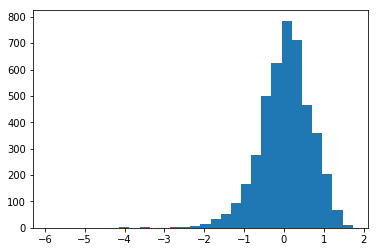

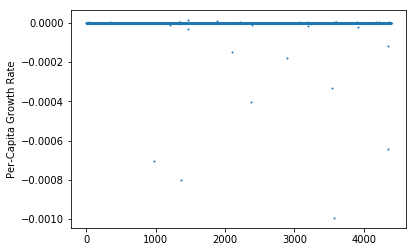

In [5]:
with open('data/EMP.dat','rb') as f:
    N0,R0,params,metadata = pickle.load(f)
EMP = Community([N0,R0],dynamics,params)
EMP.metadata=metadata

N1 = EMP.N.values.reshape(-1)
plt.hist(np.log10(N1[N1>0]),bins=30)
plt.show()

dlogNdt = pd.DataFrame(np.asarray(list(map(dNdt,EMP.N.T.values,EMP.R.T.values,params))).T,
                       index=EMP.N.index,columns=EMP.N.columns)/EMP.N
dlogNdt1 = dlogNdt.values.reshape(-1)
    
fig,ax = plt.subplots()
ax.plot(dlogNdt1[N1>0],'o',markersize=1)
ax.set_ylabel('Per-Capita Growth Rate')
plt.show()

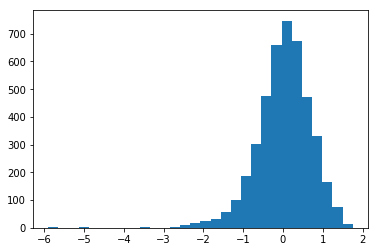

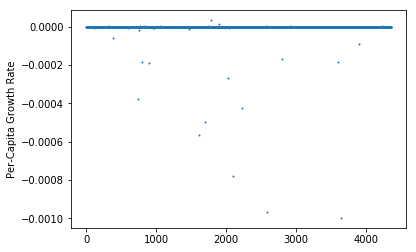

In [6]:
with open('data/EMP2.dat','rb') as f:
    N0,R0,params,metadata = pickle.load(f)
EMP = Community([N0,R0],dynamics,params)
EMP.metadata=metadata

N1 = EMP.N.values.reshape(-1)
plt.hist(np.log10(N1[N1>0]),bins=30)
plt.show()

dlogNdt = pd.DataFrame(np.asarray(list(map(dNdt,EMP.N.T.values,EMP.R.T.values,params))).T,
                       index=EMP.N.index,columns=EMP.N.columns)/EMP.N
dlogNdt1 = dlogNdt.values.reshape(-1)
    
fig,ax = plt.subplots()
ax.plot(dlogNdt1[N1>0],'o',markersize=1)
ax.set_ylabel('Per-Capita Growth Rate')
plt.show()

## Plot richness vs. harshness

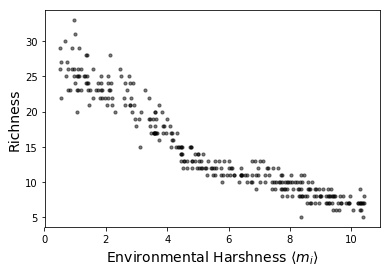

In [8]:
with open('data/EMP.dat','rb') as f:
    N,R,params,metadata = pickle.load(f)

thresh = 1e-5
fig,ax=plt.subplots()
richness = (N > thresh).sum()
ax.scatter(metadata['m'].values[richness>0],richness[richness>0],c='k',s=10,alpha=0.5)
ax.set_xlabel(r'Environmental Harshness $\langle m_i \rangle$',fontsize=14)
ax.set_ylabel('Richness',fontsize=14)
pdf = bpdf.PdfPages('plots/EMP_harshness.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Make nestedness plot function and NODF calculator

In [61]:
def PlotNestedness(N,well=None,thresh=0,ax=None):
    
    species_exist = N/N.sum() > thresh

    prevalence = species_exist.T.sum()
    richness = species_exist.sum()

    species_exist = species_exist.loc[prevalence > 0]
    prevalence = prevalence.loc[prevalence > 0]

    names = np.array(list(zip(species_exist.keys(),richness)),dtype=[('well','S100'),('richness',int)])
    names_sort = np.asarray(np.sort(names,order='richness')['well'],dtype=str)

    species = np.array(list(zip(np.arange(len(species_exist)),prevalence)),dtype=[('species',int),('prevalence',int)])
    species_sort = np.asarray(np.sort(species,order='prevalence')['species'],dtype=int)
    
    if ax is None:
        fig,ax=plt.subplots()
    N_sort = np.flipud(np.asarray(species_exist[names_sort].iloc[species_sort].values,dtype=int))
    sns.heatmap(N_sort,ax=ax,cmap=sns.color_palette("Greys",30),cbar=False)
    ax.set_yticks(())
    ax.set_xticks(())
    ax.set_xlabel('Samples (sorted by richness)',fontsize=12)
    ax.set_ylabel('Species (sorted by prevalence)',fontsize=12)
    
    return ax, N_sort

def NODF(A):
    m,n = np.shape(A)
    Ac = np.ones((n,n))*A.sum(axis=0)
    Ar = np.ones((m,m))*A.T.sum(axis=0)
    Dr = Ar<Ar.T
    Dc = Ac<Ac.T
    B = ((A.T)/(A.T.sum(axis=0))).T
    C = A/A.sum(axis=0)
    
    return 2*(np.trace(A.T.dot(Dr.dot(B)))+np.trace(A.dot(Dc.dot(C.T))))/(n*(n-1)+m*(m-1))

## Plot nestedness for single environment

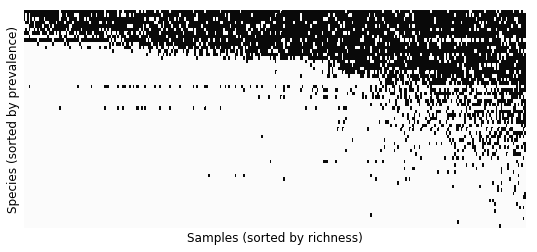

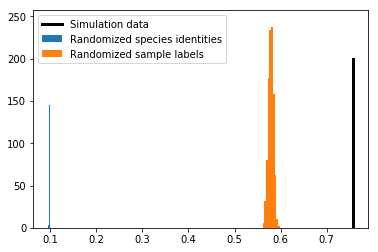

In [66]:
with open('data/EMP.dat','rb') as f:
    N,R,params,metadata = pickle.load(f)

fig,ax=plt.subplots(figsize = (9,4))
ax,N_sort = PlotNestedness(N,ax=ax,thresh=0)
pdf = bpdf.PdfPages('../plots/EMP_nestedness.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

thresh = 0
Q = 1000
null1 = []
null2 = []

for j in range(Q):
    null = N.values.copy()>thresh
    for k in range(len(null.T)):
        null[:,k] = np.random.permutation(null[:,k])
    null = null[null.sum(axis=1)>0,:]
    null = null[:,null.sum(axis=0)>0]
    null1.append(NODF(null))
    
    null = N.values.copy()>thresh
    for k in range(len(null)):
        null[k,:] = np.random.permutation(null[k,:])
    null = null[null.sum(axis=1)>0,:]
    null = null[:,null.sum(axis=0)>0]
    null2.append(NODF(null))
    
NODF_data = NODF(N.loc[N.sum(axis=1)>0].T.loc[N.sum(axis=0)>0].T.values>thresh)

fig,ax=plt.subplots()
ax.hist(null1,label='Randomized species identities')
ax.hist(null2,label='Randomized sample labels')
ax.plot([NODF_data,NODF_data],[0,200],'k',linewidth=3,label='Simulation data')
ax.legend()
pdf = bpdf.PdfPages('../Plots/EMP_NODF.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Plot nestedness with undersampled environments

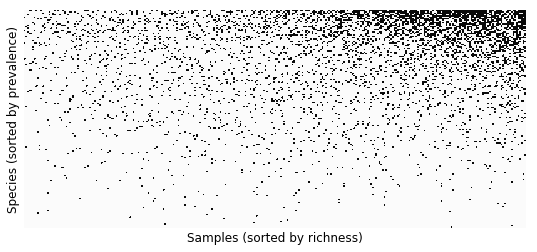

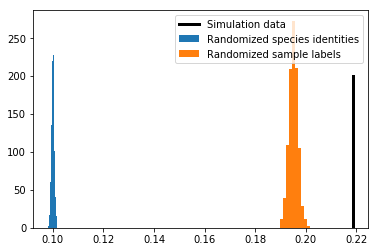

In [65]:
with open('data/EMP2.dat','rb') as f:
    N,R,params,metadata = pickle.load(f)

fig,ax=plt.subplots(figsize = (9,4))
ax,N_sort = PlotNestedness(N,ax=ax,thresh=0)
pdf = bpdf.PdfPages('../plots/EMP_nestedness.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

thresh = 0
Q = 1000
null1 = []
null2 = []

for j in range(Q):
    null = N.values.copy()>thresh
    for k in range(len(null.T)):
        null[:,k] = np.random.permutation(null[:,k])
    null = null[null.sum(axis=1)>0,:]
    null = null[:,null.sum(axis=0)>0]
    null1.append(NODF(null))
    
    null = N.values.copy()>thresh
    for k in range(len(null)):
        null[k,:] = np.random.permutation(null[k,:])
    null = null[null.sum(axis=1)>0,:]
    null = null[:,null.sum(axis=0)>0]
    null2.append(NODF(null))
    
NODF_data = NODF(N.loc[N.sum(axis=1)>0].T.loc[N.sum(axis=0)>0].T.values>thresh)

fig,ax=plt.subplots()
ax.hist(null1,label='Randomized species identities')
ax.hist(null2,label='Randomized sample labels')
ax.plot([NODF_data,NODF_data],[0,200],'k',linewidth=3,label='Simulation data')
ax.legend()
pdf = bpdf.PdfPages('../Plots/EMP_NODF_undersample.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Patterns in the Human Microbiome

For these simulations, we focus on the role of the externally supplied nutrients (e.g., diet) in the production of inter-subject compositional variability. We consider a regional pool of 5,000 species (approximately the number of OTU's in the HMP), with 300 resources (approximately the number of metabolites in E. Coli metabolism) and D_diversity chosen to obtain approximately the mean degree of the E. Coli metabolic network (cf. wagner2001small).

In [5]:
#LOAD AND PROCESS DATA
with open('data/HMP_env_family.dat','rb') as f:
    N,R,params_1,R0,metadata = pickle.load(f)
#Append information about resource mixtures
alpha = np.linspace(0,1,300)
metadata['alpha'] = np.hstack((alpha,alpha,alpha))
#Remove failed runs
composite = N.T.join(metadata).join(R0.T)
composite = composite.dropna()
metadata = composite[['alpha','Environment']]
R0 = composite[R0.index].T
N = N.T.dropna().T
R = R.T.dropna().T
#Reconstruct community
params = [{}]*len(N.T)
for k in range(len(N.T)):
    for item in ['w','g','l','tau','c','D','m']:
        params[k][item] = params_1[item]
    params[k]['R0'] = R0.values[:,k]
HMP = Community([N,R],dynamics,params)
HMP.metadata=metadata

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [7]:
#LOAD AND PROCESS DATA
with open('data/HMP_env.dat','rb') as f:
    N,R,params_1,R0,metadata = pickle.load(f)
#Append information about resource mixtures
alpha = np.linspace(0,1,300)
metadata['alpha'] = np.hstack((alpha,alpha,alpha))
#Remove failed runs
composite = N.T.join(metadata).join(R0.T)
composite = composite.dropna()
metadata = composite[['alpha','Environment']]
R0 = composite[R0.index].T
N = N.T.dropna().T
R = R.T.dropna().T
#Reconstruct community
params = [{}]*len(N.T)
for k in range(len(N.T)):
    for item in ['w','g','l','tau','c','D','m']:
        params[k][item] = params_1[item]
    params[k]['R0'] = R0.values[:,k]
HMP_nofamily = Community([N,R],dynamics,params)
HMP_nofamily.metadata=metadata

/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


## Verify convergence

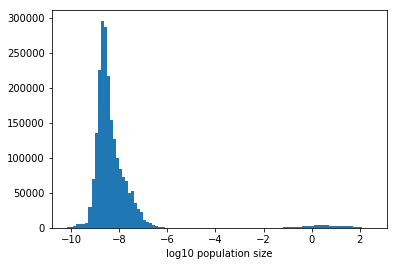

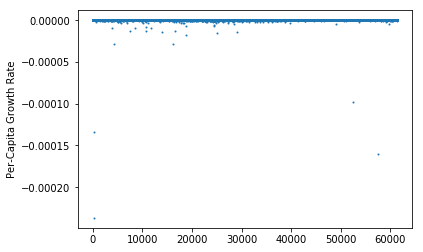

In [19]:
#look at population sizes
N1 = HMP.N.values.reshape(-1)
plt.hist(np.log10(N1[N1>0]),bins=100)
plt.gca().set_xlabel('log10 population size')
plt.show()
#Cut off numerical errors
HMP.N[HMP.N<1e-4] = 0

#Compute per-capita growth rate
dlogNdt = pd.DataFrame(np.asarray(list(map(dNdt,HMP.N.T.values,HMP.R.T.values,params))).T,
                       index=HMP.N.index,columns=HMP.N.columns)/HMP.N
dlogNdt1 = dlogNdt.values.reshape(-1)
N1 = HMP.N.values.reshape(-1)
fig,ax = plt.subplots()
ax.plot(dlogNdt1[N1>0],'o',markersize=1)
ax.set_ylabel('Per-Capita Growth Rate')
plt.show()

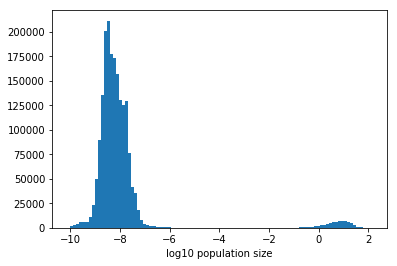

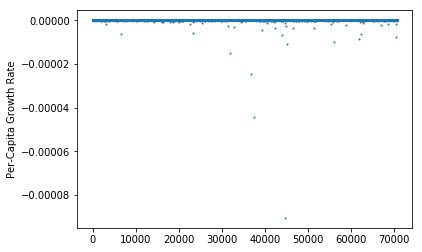

In [153]:
#look at population sizes
N1 = HMP_nofamily.N.values.reshape(-1)
plt.hist(np.log10(N1[N1>0]),bins=100)
plt.gca().set_xlabel('log10 population size')
plt.show()
#Cut off numerical errors
HMP_nofamily.N[HMP_nofamily.N<1e-4] = 0

#Compute per-capita growth rate
dlogNdt = pd.DataFrame(np.asarray(list(map(dNdt,HMP_nofamily.N.T.values,HMP_nofamily.R.T.values,params))).T,
                       index=HMP_nofamily.N.index,columns=HMP_nofamily.N.columns)/HMP_nofamily.N
dlogNdt1 = dlogNdt.values.reshape(-1)
N1 = HMP_nofamily.N.values.reshape(-1)
fig,ax = plt.subplots()
ax.plot(dlogNdt1[N1>0],'o',markersize=1)
ax.set_ylabel('Per-Capita Growth Rate')
plt.show()

## Show matrices

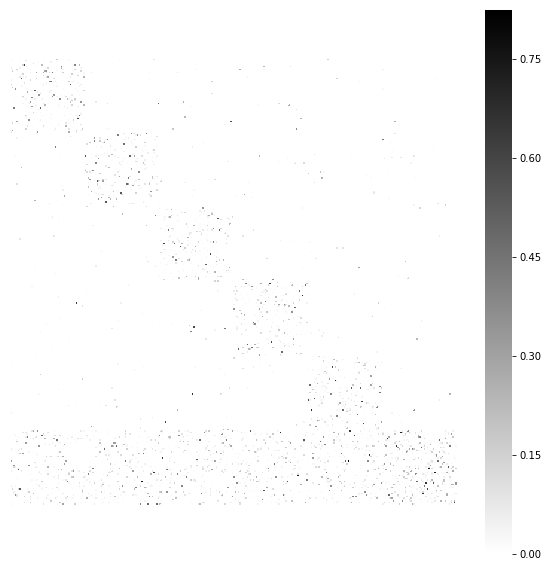

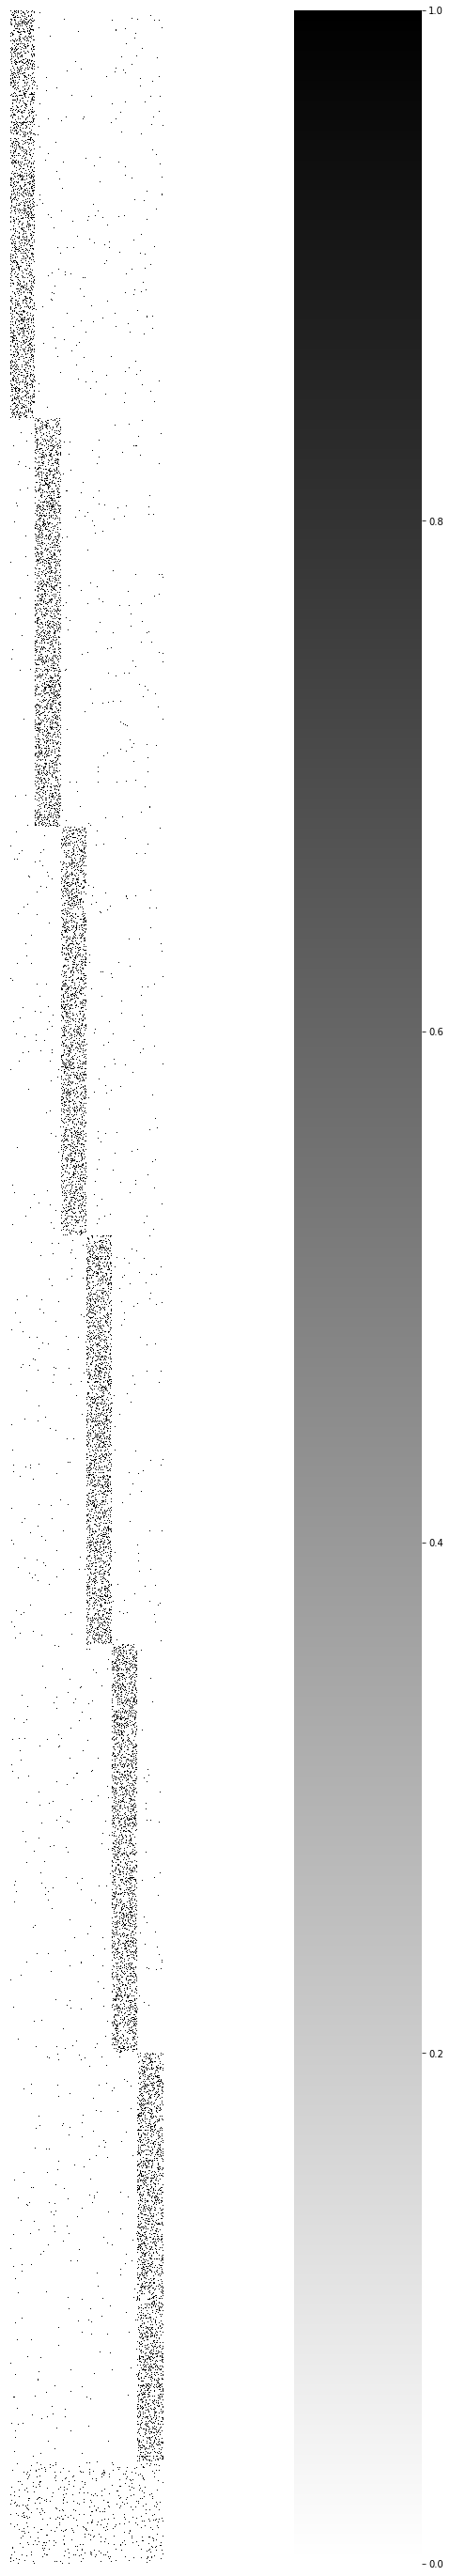

In [43]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(params[0]['D'],cmap='gray_r',ax=ax,square=True)
ax.set_xticks(())
ax.set_yticks(())
pdf = bpdf.PdfPages('../Plots/D.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax=plt.subplots(figsize=(50,50))
sns.heatmap(params[0]['c'],cmap='gray_r',ax=ax,square=True)
ax.set_xticks(())
ax.set_yticks(())
pdf = bpdf.PdfPages('../Plots/c.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Make basic plots

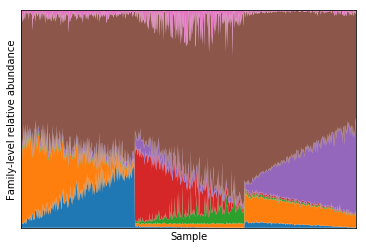

In [21]:
#STACKED BAR PLOTS
#Normalize and group by family
data = HMP.N.copy()/HMP.N.sum()
data = data.groupby(level=0).sum()
#Make plots
fig,ax=plt.subplots()
StackPlot(data,ax=ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Family-level relative abundance')
pdf = bpdf.PdfPages('../Plots/HMP_function_env.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

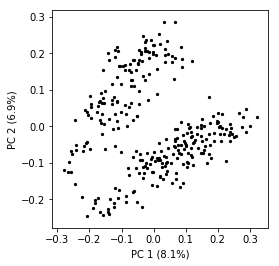

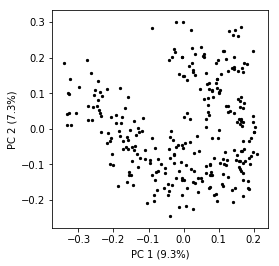

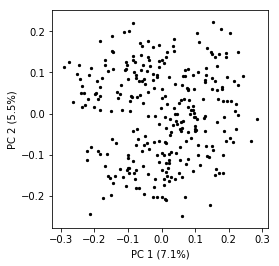

In [22]:
#PLOT PCoA FOR ONE ENVIRONMENT
for env in [1,2,3]:
    N_sugars = HMP.N.T[HMP.metadata['Environment']=='Env. '+str(env)].T
    #Make distance matrix
    HMP_dist = squareform(pdist(N_sugars.T,metric='jensenshannon'))
    #Compute PCoA and attach sample labels
    PCout = pcoa(HMP_dist)
    PCout.samples.index = N_sugars.T.index
    #Save explained variance
    explained_variance = np.around(PCout.proportion_explained.values*100,decimals=1)
    PCout = PCout.samples
    fig,ax=plt.subplots(figsize=(5,4))
    fig.subplots_adjust(left=0.3)
    PCout.plot.scatter('PC1','PC2',ax=ax,color='k',s=5)
    ax.set_xlabel('PC 1 ('+str(explained_variance[0])+'%)')
    ax.set_ylabel('PC 2 ('+str(explained_variance[1])+'%)')
    pdf = bpdf.PdfPages('../Plots/HMP_enterotypes_env'+str(env)+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

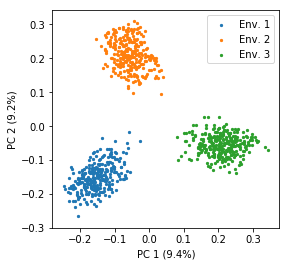

In [23]:
#PLOT PCoA FOR ALL SAMPLES
#Make distance matrix
HMP_dist = squareform(pdist(HMP.N.T.values,metric='jensenshannon'))
#Compute PCoA and attach sample labels
PCout = pcoa(HMP_dist)
PCout.samples.index = HMP.N.T.index
#Save explained variance
explained_variance = np.around(PCout.proportion_explained.values*100,decimals=1)
#Make dataframe with metadata
PCout = PCout.samples.join(HMP.metadata)
colors = sns.color_palette()
#Plot groups
groups = PCout.groupby('Environment')
fig,ax=plt.subplots(figsize=(4.5,4))
fig.subplots_adjust(left=0.2)
k=0
for name, group in groups:
    group.plot.scatter('PC1','PC2',ax=ax,label=name,color = colors[k],s=5)
    k+=1
ax.set_xlabel('PC 1 ('+str(explained_variance[0])+'%)')
ax.set_ylabel('PC 2 ('+str(explained_variance[1])+'%)')
ax.legend()
pdf = bpdf.PdfPages('../Plots/HMP_foodsource_JS_env.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Plot "additivity"

### No family or metabolic structure

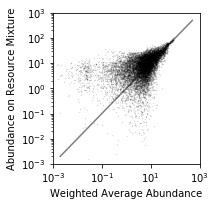

Coefficients: 
 [[1.07103177]]
Mean squared error: 3.18
Variance score: 0.59


In [8]:
HMP_nofamily.N[HMP.N<1e-4] = 0
wells = HMP_nofamily.metadata.index[HMP_nofamily.metadata['Environment']=='Env. 2']
N = HMP_nofamily.N[wells]
alpha = HMP_nofamily.metadata['alpha'].loc[wells].values
extremes = [wells[0],wells[-1]]
average = [(1-alpha[k])*N[extremes[0]].values+alpha[k]*N[extremes[1]].values for k in range(1,len(wells)-1)]
N = N.values[:,1:-1]

fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.22,bottom=0.18)
Nmin = 1e-3
Nmax = 1e3
common = []
for k in range(len(wells)-2):
    common.append(np.asarray(list(set(np.where(average[k]>0)[0]).intersection(set(np.where(N[:,k]>0)[0])))))
    ax.scatter(average[k][common[k]],N[common[k],k],s=0.1,c='k',alpha=0.2)
ax.plot([Nmin*2,Nmax/2],[Nmin*2,Nmax/2],'k',alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([Nmin,Nmax])
ax.set_ylim([Nmin,Nmax])
ax.set_ylabel('Abundance on Resource Mixture')
ax.set_xlabel('Weighted Average Abundance')
pdf = bpdf.PdfPages('../Plots/HMP_additivity_nofamily.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()


average_all = np.asarray([average[k][common[k][j]] for k in range(len(wells)-2) for j in range(len(common[k]))])
mix_all = np.asarray([N[common[k][j],k] for k in range(len(wells)-2) for j in range(len(common[k]))])

#train_sample = np.random.choice(list(range(len(average_all))),size=len(average_all))
#test_sample = np.asarray(list(set(range(len(average_all))).difference(set(train_sample))))

train_sample = test_sample = np.arange(len(average_all),dtype=int)
N_average_train = average_all[train_sample][:,np.newaxis]
N_mix_train = mix_all[train_sample][:,np.newaxis]
N_average_test = average_all[test_sample][:,np.newaxis]
N_mix_test = mix_all[test_sample][:,np.newaxis]
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(N_average_train, N_mix_train)
# Make predictions using the testing set
N_mix_pred = regr.predict(N_average_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(N_mix_test, N_mix_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(N_mix_test, N_mix_pred))

### With family and metabolic structure

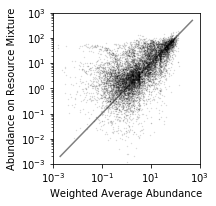

Coefficients: 
 [[0.79337293]]
Mean squared error: 247.70
Variance score: 0.48


In [9]:
HMP.N[HMP.N<1e-4] = 0
wells = HMP.metadata.index[HMP.metadata['Environment']=='Env. 2']
N = HMP.N[wells]
alpha = HMP.metadata['alpha'].loc[wells].values
extremes = [wells[0],wells[-1]]
average = [(1-alpha[k])*N[extremes[0]].values+alpha[k]*N[extremes[1]].values for k in range(1,len(wells)-1)]
N = N.values[:,1:-1]

fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.22,bottom=0.18)
Nmin = 1e-3
Nmax = 1e3
common = []
for k in range(len(wells)-2):
    common.append(np.asarray(list(set(np.where(average[k]>0)[0]).intersection(set(np.where(N[:,k]>0)[0])))))
    ax.scatter(average[k][common[k]],N[common[k],k],s=0.1,c='k',alpha=0.2)
ax.plot([Nmin*2,Nmax/2],[Nmin*2,Nmax/2],'k',alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([Nmin,Nmax])
ax.set_ylim([Nmin,Nmax])
ax.set_ylabel('Abundance on Resource Mixture')
ax.set_xlabel('Weighted Average Abundance')
pdf = bpdf.PdfPages('../Plots/HMP_additivity.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()


average_all = np.asarray([average[k][common[k][j]] for k in range(len(wells)-2) for j in range(len(common[k]))])
mix_all = np.asarray([N[common[k][j],k] for k in range(len(wells)-2) for j in range(len(common[k]))])

#train_sample = np.random.choice(list(range(len(average_all))),size=len(average_all))
#test_sample = np.asarray(list(set(range(len(average_all))).difference(set(train_sample))))

train_sample = test_sample = np.arange(len(average_all),dtype=int)
N_average_train = average_all[train_sample][:,np.newaxis]
N_mix_train = mix_all[train_sample][:,np.newaxis]
N_average_test = average_all[test_sample][:,np.newaxis]
N_mix_test = mix_all[test_sample][:,np.newaxis]
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(N_average_train, N_mix_train)
# Make predictions using the testing set
N_mix_pred = regr.predict(N_average_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(N_mix_test, N_mix_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(N_mix_test, N_mix_pred))

### Smaller dataset with no stochastic colonization

#### Generate new data

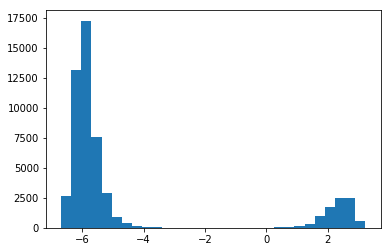

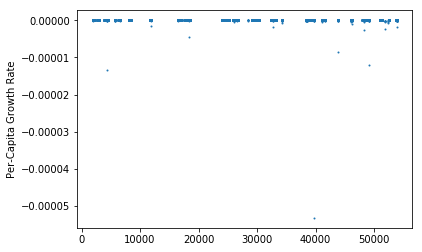

In [142]:
with open('data/EMP.dat','rb') as f:
    N0,R0,params,metadata = pickle.load(f)

n_wells = 300
R0_food = 10000
R0 = np.zeros((len(R0),n_wells))
alpha = np.linspace(0,1,n_wells)
R0[0,:] = alpha*R0_food
R0[1,:] = (1-alpha)*R0_food
N0 = np.ones((len(N0),n_wells))

c = params[0]['c']
D = params[0]['D']

m = 1+0.01*np.random.randn(len(N0))
params=[{'w':1,
        'g':1,
        'l':0.8,
        'R0':R0[:,k],
        'r':1.,
        'tau':1
        } for k in range(len(N0.T))]
for k in range(len(params)):
    params[k]['c'] = c
    params[k]['D'] = D
    params[k]['m'] = m

gradient = Community([N0,R0],dynamics,params)
gradient.SteadyState()

N1 = gradient.N.values.reshape(-1)
plt.hist(np.log10(N1[N1>0]),bins=30)
plt.show()
gradient.N[gradient.N<1e-2]=0
dlogNdt = pd.DataFrame(np.asarray(list(map(dNdt,gradient.N.T.values,gradient.R.T.values,params))).T,
                       index=gradient.N.index,columns=gradient.N.columns)/gradient.N
dlogNdt1 = dlogNdt.values.reshape(-1)
fig,ax = plt.subplots()
ax.plot(dlogNdt1[N1>0],'o',markersize=1)
ax.set_ylabel('Per-Capita Growth Rate')
plt.show()

#### Plot additivity

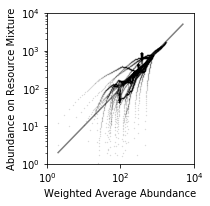

Coefficients: 
 [[0.98655769]]
Mean squared error: 13258.00
Variance score: 0.84


In [143]:
N = gradient.N
wells = N.keys()
extremes = [wells[0],wells[-1]]
average = [(1-alpha[k])*N[extremes[0]].values+alpha[k]*N[extremes[1]].values for k in range(1,len(wells)-1)]
N = N.values[:,1:-1]

fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.22,bottom=0.18)
Nmin = 1
Nmax = 1e4
common = []
for k in range(n_wells-2):
    common.append(np.asarray(list(set(np.where(average[k]>0)[0]).intersection(set(np.where(N[:,k]>0)[0])))))
for k in range(n_wells-2):
    ax.scatter(average[k][common[k]],N[common[k],k],s=0.1,alpha=0.2,color='k')
ax.plot([Nmin*2,Nmax/2],[Nmin*2,Nmax/2],'k',alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Abundance on Resource Mixture')
ax.set_xlabel('Weighted Average Abundance')
ax.set_xlim([Nmin,Nmax])
ax.set_ylim([Nmin,Nmax])
pdf = bpdf.PdfPages('../Plots/simple_additivity.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

average_all = np.asarray([average[k][common[k][j]] for k in range(len(wells)-2) for j in range(len(common[k]))])
mix_all = np.asarray([N[common[k][j],k] for k in range(len(wells)-2) for j in range(len(common[k]))])

train_sample = np.random.choice(list(range(len(average_all))),size=len(average_all))
test_sample = np.asarray(list(set(range(len(average_all))).difference(set(train_sample))))


N_average_train = average_all[train_sample][:,np.newaxis]
N_mix_train = mix_all[train_sample][:,np.newaxis]
N_average_test = average_all[test_sample][:,np.newaxis]
N_mix_test = mix_all[test_sample][:,np.newaxis]
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(N_average_train, N_mix_train)
# Make predictions using the testing set
N_mix_pred = regr.predict(N_average_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
        % mean_squared_error(N_mix_test, N_mix_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(N_mix_test, N_mix_pred))

## Plot Dissimilarity-Overlap Curve

In [148]:
#Define dissimilarity and overlap
def D(x,y,thresh=0):
    S = np.where(np.logical_and(x>thresh,y>thresh))[0]
    
    xhat = x[S]/x[S].sum()
    yhat = y[S]/y[S].sum()
    m = (xhat+yhat)/2
    
    return np.sqrt(0.5*(xhat*np.log(xhat/m)+yhat*np.log(yhat/m)).sum())

def O(x,y,thresh=0):
    S = np.where(np.logical_and(x>thresh,y>thresh))[0]
    
    xtilde = x/x.sum()
    ytilde = y/y.sum()
    
    return 0.5*(xtilde[S]+ytilde[S]).sum()

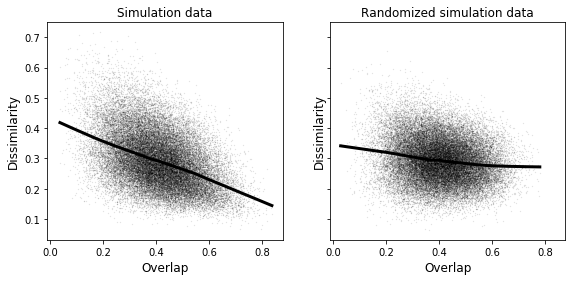

In [156]:
#Select data and set threshold
wells = HMP.metadata.index[HMP.metadata['Environment']=='Env. 2']
N = HMP.N[wells]
thresh = 0

#Compute dissimilarity and overlap
Dlist = []
Olist = []
for run1 in range(len(N.T)):
    for run2 in range(run1+1,len(N.T)):
        x = N[wells[run1]].values
        y = N[wells[run2]].values
        if np.max(x) > thresh and np.max(y) > thresh and D(x,y,thresh=thresh) > thresh:
            Dlist.append(D(x,y,thresh=thresh))
            Olist.append(O(x,y,thresh=thresh))

#Compute dissimilarity and overlap for randomized data
Dlist_null = []
Olist_null = []
null = N.values.copy()
for k in range(len(null)):
    Inonzeros = np.where(null[k,:]>0)[0]
    null[k,Inonzeros] = null[k,np.random.permutation(Inonzeros)]
for run1 in range(len(N.T)):
    for run2 in range(run1+1,len(N.T)):
            x = null[:,run1]
            y = null[:,run2]
            if np.max(x) > thresh and np.max(y) > thresh and D(x,y,thresh=thresh) > thresh:
                Dlist_null.append(D(x,y,thresh=thresh))
                Olist_null.append(O(x,y,thresh=thresh))

#Make into numpy arrays
Olist = np.asarray(Olist)
Dlist = np.asarray(Dlist)
Olist_null = np.asarray(Olist_null)
Dlist_null = np.asarray(Dlist_null)

#Make and annotate plots
fig,ax=plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,4))
fig.subplots_adjust(left=0.2,right=0.8)
#subsample = np.random.choice(np.arange(len(Olist),dtype=int),size=10000)
subsample = np.arange(len(Olist),dtype=int)

ax[0].scatter(Olist[subsample],Dlist[subsample],c='k',s=0.05,alpha=0.2)
ax[0].set_xlabel('Overlap',fontsize=12)
ax[0].set_ylabel('Dissimilarity',fontsize=12)
out_real = lowess(Dlist[subsample],Olist[subsample],return_sorted=True,frac=0.2)
ax[0].plot(out_real[:,0],out_real[:,1],'k',lw=3)
ax[0].set_title('Simulation data',fontsize=12)
#ax[0].set_xlim((0,0.4))

ax[1].scatter(Olist_null[subsample],Dlist_null[subsample],c='k',s=0.05,alpha=0.2)
ax[1].set_xlabel('Overlap',fontsize=12)
ax[1].set_ylabel('Dissimilarity',fontsize=12)
out_null = lowess(Dlist_null[subsample],Olist_null[subsample],return_sorted=True,frac=0.2)
ax[1].plot(out_null[:,0],out_null[:,1],'k',lw=3)
ax[1].set_title('Randomized simulation data',fontsize=12)
#ax[1].set_ylim((0.1,0.6))
    
pdf = bpdf.PdfPages('../Plots/DOC_big.pdf')
pdf.savefig(fig)
pdf.close()

plt.show()